# Orbiting the Sun

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [1]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/modsim.py')

In [2]:
# import functions from modsim

from modsim import *

In a previous example, we modeled the interaction between the Earth and the Sun, simulating what would happen if the Earth stopped in its orbit and fell straight into the Sun.

Now let's extend the model to two dimensions and simulate one revolution of the Earth around the Sun, that is, one year.

At perihelion, the distance from the Earth to the Sun is 147.09 million km and its velocity is 30,290 m/s.

In [3]:
r_0 = 147.09e9     # initial distance m
v_0 = 30.29e3      # initial velocity m/s

Here are the other constants we'll need, all with about 4 significant digits.

In [4]:
G = 6.6743e-11     # gravitational constant N / kg**2 * m**2
m1 = 1.989e30      # mass of the Sun kg
m2 = 5.972e24      # mass of the Earth kg
t_end = 3.154e7    # one year in seconds

**Exercise:** Put the initial conditions in a `State` object with variables `x`, `y`, `vx`, and `vy`.
Create a `System` object with variables `init` and `t_end`.

In [15]:
# Solution goes here
init = State(x=r_0, y=0, vx=0, vy=-v_0)
init

x     1.470900e+11
y     0.000000e+00
vx    0.000000e+00
vy   -3.029000e+04
Name: state, dtype: float64

In [16]:
# Solution goes here
system = System(init=init, G=G, m1=m1, m2=m2, t_end=t_end)
system

namespace(init=x     1.470900e+11
               y     0.000000e+00
               vx    0.000000e+00
               vy   -3.029000e+04
               Name: state, dtype: float64,
          G=6.6743e-11,
          m1=1.989e+30,
          m2=5.972e+24,
          t_end=31540000.0)

**Exercise:** Write a function called `universal_gravitation` that takes a `State` and a `System` and returns the gravitational force of the Sun on the Earth as a `Vector`.

Test your function with the initial conditions; the result should be a Vector with approximate components:

```
x   -3.66e+22
y   0
```

In [17]:
# Solution goes here
def universal_gravitation(state, system):
    x, y, vx, vy = state
    
    r = Vector(x, y)
    r_mag = vector_mag(r)
    r_hat = vector_hat(r)
    
    force = G * m1 * m2 / r_mag**2
    force_vector = -force * r_hat
    
    return force_vector

In [18]:
# Solution goes here
universal_gravitation(init, system)

x   -3.664325e+22
y   -0.000000e+00
Name: component, dtype: float64

**Exercise:** Write a slope function that takes a timestamp, a `State`, and a `System` and computes the derivatives of the state variables.

Test your function with the initial conditions.  The result should be a sequence of four values, approximately

```
0.0, -30290.0, -0.006, 0.0
```

In [19]:
# Solution goes here
def slope_func(t, state, system):
    x, y, vx, vy = state
    
    force = universal_gravitation(state, system)
    dxdt = vx
    dydt = vy
    dvxdt = force.x / m2
    dvydt = force.y / m2
    
    return dxdt, dydt, dvxdt, dvydt

In [20]:
# Solution goes here
slope_func(0, init, system)

(0.0, -30290.0, np.float64(-0.006135842607445133), np.float64(-0.0))

**Exercise:**  Use `run_solve_ivp` to run the simulation.
Save the return values in variables called `results` and `details`.

In [21]:
# Solution goes here
results, details = run_solve_ivp(system, slope_func)
details.message

'The solver successfully reached the end of the integration interval.'

You can use the following function to plot the results.

In [22]:
from matplotlib.pyplot import plot

def plot_trajectory(results):
    x = results.x / 1e9
    y = results.y / 1e9

    make_series(x, y).plot(label='orbit')
    plot(0, 0, 'yo')

    decorate(xlabel='x distance (million km)',
             ylabel='y distance (million km)')

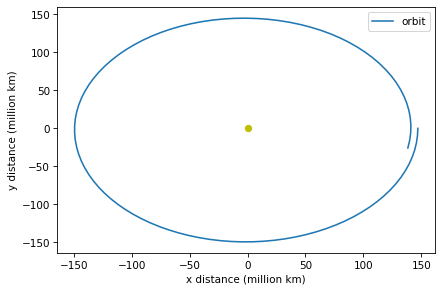

In [23]:
plot_trajectory(results)

You will probably see that the earth does not end up back where it started, as we expect it to after one year.
The following cells compute the error, which is the distance between the initial and final positions.

In [28]:
def calc_error(results, system):
    return results.iloc[-1] - system.init

In [29]:
calc_error(results, system)

x    -8.646326e+09
y    -2.579159e+10
vx   -5.938841e+03
vy   -1.228148e+02
dtype: float64

In [24]:
error = results.iloc[-1] - system.init
error

x    -8.646326e+09
y    -2.579159e+10
vx   -5.938841e+03
vy   -1.228148e+02
dtype: float64

In [25]:
offset = Vector(error.x, error.y)
vector_mag(offset) / 1e9

np.float64(27.202295784722274)

The problem is that the algorithm used by `run_solve_ivp` does not work very well with systems like this.
There are two ways we can improve it.

`run_solve_ivp` takes a keyword argument, `rtol`, that specifies the "relative tolerance", which determines the size of the time steps in the simulation.  Lower values of `rtol` require smaller steps, which yield more accurate results.
The default value of `rtol` is `1e-3`.  

**Exercise:** Try running the simulation again with smaller values, like `1e-4` or `1e-5`, and see what effect it has on the magnitude of `offset`.

In [27]:
results2, details2 = run_solve_ivp(system, slope_func, rtol=1e-4)
details2.message

'The solver successfully reached the end of the integration interval.'

In [30]:
calc_error(results2, system)

x    -3.982165e+08
y    -2.185681e+09
vx   -4.419082e+02
vy   -4.022881e+01
dtype: float64

In [31]:
details2.nfev

158

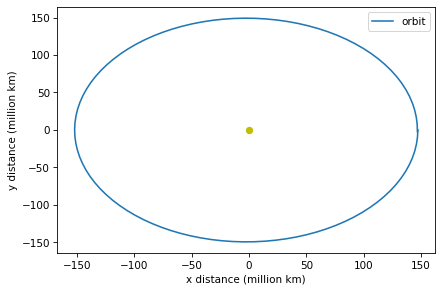

In [41]:
plot_trajectory(results2)

In [32]:
results3, details3 = run_solve_ivp(system, slope_func, rtol=1e-5)
details3.message

'The solver successfully reached the end of the integration interval.'

In [33]:
calc_error(results3, system)

x    -1.145469e+07
y     3.252164e+07
vx    6.552941e+00
vy   -1.137655e+00
dtype: float64

In [34]:
details3.nfev

206

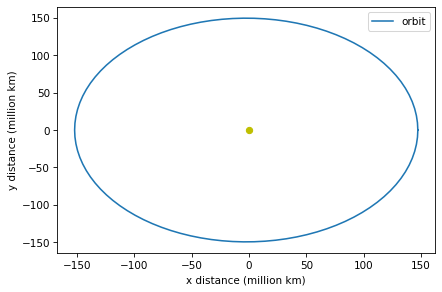

In [36]:
plot_trajectory(results3)

The other way to improve the results is to use a different algorithm.  `run_solve_ivp` takes a keyword argument, `method`, that specifies which algorithm it should use.  The default is `RK45`, which is a good, general-purpose algorithm, but not particularly good for this system.  One of the other options is `RK23`, which is usually less accurate than `RK45` (with the same step size), but for this system it turns out to be unreasonably good, [for reasons I don't entirely understand](https://mathoverflow.net/questions/314940/celestial-mechanics-and-runge-kutta-methods).
Yet another option is 'DOP853', which is particularly good when `rtol` is small.

**Exercise:** Run the simulation with one of these methods and see what effect it has on the results.  To get a sense of how efficient the methods are, display `details.nfev`, which is the number of times `run_solve_ivp` called the slope function.

In [26]:
details.nfev

146

In [37]:
results4, details4 = run_solve_ivp(system, slope_func, method='RK23')
details4.message

'The solver successfully reached the end of the integration interval.'

In [38]:
calc_error(results4, system)

x     2.591702e+08
y     1.291170e+09
vx    2.603717e+02
vy    2.824037e+01
dtype: float64

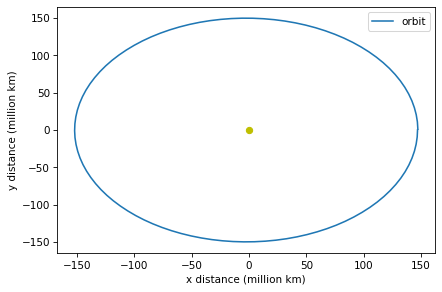

In [39]:
plot_trajectory(results4)

In [40]:
details4.nfev

137

## Animation

You can use the following draw function to animate the results, if you want to see what the orbit looks like (not in real time).

In [43]:
xlim = results.x.min(), results.x.max()
ylim = results.y.min(), results.y.max()

def draw_func(t, state):
    x, y, vx, vy = state
    plot(x, y, 'b.')
    plot(0, 0, 'yo')
    decorate(xlabel='x distance (million km)',
             ylabel='y distance (million km)',
             xlim=xlim,
             ylim=ylim)

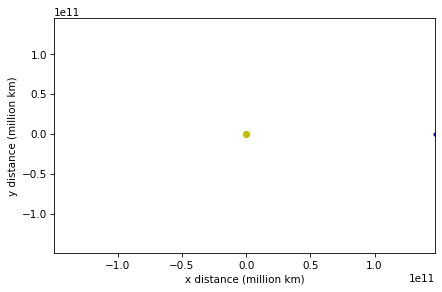

In [45]:
animate(results3, draw_func)